In [1]:
import os
import sys
import numpy as np
from PIL import Image
from keras.models import Sequential
from keras.layers import Dropout, Dense, BatchNormalization
from keras.layers import Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop, Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

from random import shuffle
from glob import glob
import shutil
from shutil import copyfile

In [2]:
# Code for Correcting Error
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


# Define Print Progress Bar Function
def print_progress(iteration, total, prefix='>> Progress:', suffix='Complete', decimals=1, bar_length=55):
    str_format = "{0:." + str(decimals) + "f}"
    current_progress = iteration / float(total)
    percents = str_format.format(100 * current_progress)
    filled_length = int(round(bar_length * current_progress))
    bar = "■" * filled_length + '□' * (bar_length - filled_length)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

1 Physical GPUs, 1 Logical GPUs


In [3]:
def move_data(train_dir, base_dir):
    
    # 1차적으로 모든 데이터를 train_dir로 옮겨준다
    for subdir, dirs, files in os.walk(base_dir):
        files = [f for f in files if not f[0] == '.']
        dirs[:] = [d for d in dirs if not d[0] == '.']
        if subdir == base_dir:
            continue
           
        fish_type = subdir[len(base_dir):]
        os.makedirs(train_dir + fish_type)
        for file in files:
            copyfile(os.path.join(subdir, file), os.path.join(train_dir + fish_type, file))
        
        print(f'number of files in {subdir[len(base_dir):]} = {len(os.listdir(subdir))}')

In [4]:
def divide_data(valid_dir, train_dir):
    
    for subdir, dirs, files in os.walk(train_dir):
        files = [f for f in files if not f[0] == '.']
        dirs[:] = [d for d in dirs if not d[0] == '.']
        if subdir == train_dir:
            print(subdir)
            continue
        
        # 이후 validation에 사용할 랜덤 데이터를 옮겨준다
        valid_files = np.random.choice(files, int(len(os.listdir(subdir)) * 0.3), replace=False)
        
        print(f'number of validation files = {len(valid_files)}')
        
        fish_type = subdir[len(train_dir):]
        os.makedirs(valid_dir + fish_type)
        for file in valid_files:
            shutil.move(os.path.join(subdir, file), os.path.join(valid_dir+fish_type, file))       

In [5]:
def data_augmentation(train_dir):
    for subdir, dirs, files in os.walk(train_dir):
        files = [f for f in files if not f[0] == '.']
        dirs[:] = [d for d in dirs if not d[0] == '.']
        if subdir == train_dir:
            continue
        fish_type = subdir[len(train_dir):]
        for file in files:
#             print(os.path.join(train_dir+fish_type, file))
            raw_img = Image.open(os.path.join(train_dir+fish_type, file))           
            fish_img = raw_img.convert("RGB")
        
            flipped = fish_img.transpose(Image.FLIP_LEFT_RIGHT)
            flipped.save(os.path.join(train_dir+fish_type, "flipped_"+file), 'JPEG')
            
            fish_img.transpose(Image.ROTATE_90).save(os.path.join(train_dir+fish_type, "r90_"+file), 'JPEG')
            fish_img.transpose(Image.ROTATE_180).save(os.path.join(train_dir+fish_type, "r180_"+file), 'JPEG')
            fish_img.transpose(Image.ROTATE_270).save(os.path.join(train_dir+fish_type, "r270_"+file), 'JPEG')
            
            flipped.transpose(Image.ROTATE_90).save(os.path.join(train_dir+fish_type, "f90_"+file), 'JPEG')
            flipped.transpose(Image.ROTATE_180).save(os.path.join(train_dir+fish_type, "f180_"+file), 'JPEG')
            flipped.transpose(Image.ROTATE_270).save(os.path.join(train_dir+fish_type, "f270_"+file), 'JPEG')

In [6]:
base_dir = './dataset_nobg'
train_dir = './training_nobg/train/'
valid_dir = './training_nobg/validate/'

# if directory is empty, copy files
if not os.listdir(train_dir):
    print('MOVING DATA\n')
    move_data(train_dir, base_dir)
    print('DIVIDNG DATA')
    divide_data(valid_dir, train_dir)
else:
    print('***DIRECTORY NOT EMPTY***')
    print('          * * *')
    shutil.rmtree(train_dir)
    shutil.rmtree(valid_dir)
    print('***DIRECTORY EMPTIED***')
    os.makedirs(train_dir)
    os.makedirs(valid_dir)
    print('\nMOVING DATA')
    move_data(train_dir, base_dir)
    print('DIVIDNG DATA')
    divide_data(valid_dir, train_dir)
    print('***DATA DIVISION DONE***')


***DIRECTORY NOT EMPTY***
          * * *
***DIRECTORY EMPTIED***

MOVING DATA
number of files in /crucian_carp = 75
number of files in /rockfish = 75
number of files in /mandarin = 67
number of files in /red_snapper = 72
number of files in /flatfish = 72
DIVIDNG DATA
./training_nobg/train/
number of validation files = 22
number of validation files = 22
number of validation files = 20
number of validation files = 21
number of validation files = 21
***DATA DIVISION DONE***


In [7]:
data_augmentation(train_dir)

In [8]:
types = [f for f in os.listdir(base_dir) if not f.startswith('.')]
cnt = len(types)

img_height = 112
img_width = 112

# print(cnt)
print(types)

['crucian_carp', 'rockfish', 'mandarin', 'red_snapper', 'flatfish']


In [9]:
# Parsing Images
# # Parsing Training Image
x_train = []
y_train = []

# ## Image Parsing Process
print("\nTraining Image Parsing Started")
for idx, type in enumerate(types):
    print("<" + type + "> Image Parsing Progressing")
    label = [0 for i in range(cnt)]
    label[idx] = 1
    img_dir = train_dir + type + '/'
    for top, folder, file in os.walk(img_dir):
        for filename in file:
            print_progress(file.index(filename) + 1, len(file))
            img = Image.open(img_dir + filename)
            img = img.convert("RGB")
            img = img.resize((img_width, img_height))
            img_data = np.asarray(img)
            x_train.append(img_data/255)
            y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)
print("Training Image Parsing Finished")


Training Image Parsing Started
<crucian_carp> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<rockfish> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<mandarin> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<red_snapper> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<flatfish> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
Training Image Parsing Finished


In [10]:
# # Parsing Validation Image
x_val = []
y_val = []
# ## Image Parsing Process
print("\nValidation Image Parsing Started")
for idx, type in enumerate(types):
    print("<" + type + "> Image Parsing Progressing")
    label = [0 for i in range(cnt)]
    label[idx] = 1
    img_dir = valid_dir + type + '/'
    for top, folder, file in os.walk(img_dir):
        for filename in file:
            print_progress(file.index(filename) + 1, len(file))
            img = Image.open(img_dir + filename)
            img = img.convert("RGB")
            img = img.resize((img_width, img_height))
            img_data = np.asarray(img)
            x_val.append(img_data/255)
            y_val.append(label)
x_val = np.array(x_val)
y_val = np.array(y_val)
print("Validation Image Parsing Finished\n")


Validation Image Parsing Started
<crucian_carp> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<rockfish> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<mandarin> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<red_snapper> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
<flatfish> Image Parsing Progressing
>> Progress: |■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 100.0% Complete
Validation Image Parsing Finished



In [11]:
# Build CNN Model
Fish_Classifier = Sequential()
# # Feature Extraction Layer
# ## Convolution Layer
Fish_Classifier.add(Conv2D(input_shape=(img_width, img_height, 3), filters=64, kernel_size=(3, 3), strides=(1, 1),
                           padding='same', kernel_regularizer=l2(0.01)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
# ## Pooling Layer (Max Pooling)
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
Fish_Classifier.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
Fish_Classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
Fish_Classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                           kernel_regularizer=l2(0.001)))
Fish_Classifier.add(BatchNormalization())
Fish_Classifier.add(Activation('relu'))
Fish_Classifier.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# # Fully-Connected Layer
Fish_Classifier.add(Flatten())
Fish_Classifier.add(Dense(4096, activation='relu'))
Fish_Classifier.add(Dropout(0.5))
Fish_Classifier.add(Dense(4096, activation='relu'))
Fish_Classifier.add(Dropout(0.5))
# ## Output Layer
Fish_Classifier.add(Dense(cnt, activation='softmax'))

In [12]:
# Set Optimizer (RMSprop) and Learning Rate
#lr_decay = ExponentialDecay(initial_learning_rate=0.1, decay_steps=1, decay_rate=0.9)
opt = Adam(learning_rate=0.0001)
Fish_Classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

Fish_Classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0

In [13]:
# Set Training Condition
Datetime = datetime.datetime.now().strftime('%m%d_%H%M')
# # Set Saving Path of Trained Model
Check_Pointer = ModelCheckpoint(filepath="augmented_model_without_bg.h5", monitor='val_loss', verbose=1, save_best_only=True)
Early_Stopping_Callback = EarlyStopping(monitor='val_loss', patience=1000)
# # Train Model
history = Fish_Classifier.fit(x_train, y_train, epochs=1000, batch_size=16, verbose=1, validation_data=(x_val, y_val),
                              callbacks=[Early_Stopping_Callback, Check_Pointer])

Epoch 1/1000
128/128 [==============================] - 8s 38ms/step - loss: 7.2437 - acc: 0.4111 - val_loss: 6.1670 - val_acc: 0.1981

Epoch 00001: val_loss improved from inf to 6.16702, saving model to augmented_model_without_bg.h5
Epoch 2/1000
128/128 [==============================] - 4s 33ms/step - loss: 3.5540 - acc: 0.6575 - val_loss: 7.5805 - val_acc: 0.1981

Epoch 00002: val_loss did not improve from 6.16702
Epoch 3/1000
128/128 [==============================] - 4s 32ms/step - loss: 3.3221 - acc: 0.7279 - val_loss: 6.5651 - val_acc: 0.2075

Epoch 00003: val_loss did not improve from 6.16702
Epoch 4/1000
128/128 [==============================] - 4s 32ms/step - loss: 3.0145 - acc: 0.7804 - val_loss: 3.4851 - val_acc: 0.6132

Epoch 00004: val_loss improved from 6.16702 to 3.48514, saving model to augmented_model_without_bg.h5
Epoch 5/1000
128/128 [==============================] - 4s 32ms/step - loss: 2.9255 - acc: 0.7937 - val_loss: 2.8006 - val_acc: 0.8302

Epoch 00005: val_l

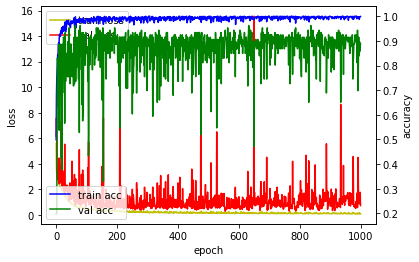

In [14]:
# Visualize Training Process and Result
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()